In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, HDBSCAN, MeanShift, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

from data_loader import load_xenium_breast_cancer

from prismo import PRISMO

tab20 = plt.get_cmap('tab20').colors
tab20 = [colors.rgb2hex(color) for color in tab20]

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-pac

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
data = load_xenium_breast_cancer()
sc.pp.highly_variable_genes(data["group_chromium"]["rna"], subset=True, n_top_genes=4000)
data["group_chromium"]["rna"].var_names = (data["group_chromium"]["rna"].var["symbol"].astype(str))
data["group_xenium"]["rna"].var_names = (data["group_xenium"]["rna"].var["symbol"].astype(str))

In [4]:
df = data["group_xenium"]["rna"].obs[["celltype", "x_centroid", "y_centroid"]]
df.columns = ["celltype", "x", "y"]

# Number of neighbors
n_neighbors = 15

# Fit the NearestNeighbors model
coords = df[['x', 'y']].values
nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Function to get celltype composition of nearest neighbors
def get_composition(indices, df):
    neighbor_indices = indices[1:]  # Exclude the first index as it is the point itself
    neighbor_celltypes = df.iloc[neighbor_indices]['celltype']
    return neighbor_celltypes.value_counts().to_dict()

# Apply the function to each row
df['composition'] = [get_composition(indices[i], df) for i in range(len(df))]

# Expand the composition column into multiple columns
composition_df = pd.json_normalize(df['composition']).fillna(0)
composition_df.index = df.index

# Concatenate the expanded columns back to the original DataFrame
df = pd.concat([df.drop(columns=['composition']), composition_df], axis=1)

# Select the composition columns
composition_columns = composition_df.columns
composition_data = df[composition_columns]

# Normalize the composition data
scaler = StandardScaler()
composition_data_normalized = scaler.fit_transform(composition_data)

/tmp/ipykernel_648997/655678474.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


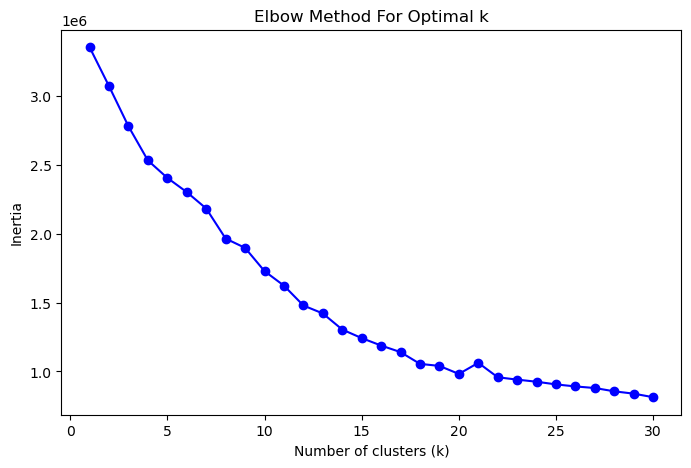

In [5]:
# Define the range of k values to try
k_values = range(1, 31)
inertia_values = []

# Compute K-means for each k and store the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(composition_data_normalized)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
kmeans = KMeans(n_clusters=10, random_state=42)

adata = data["group_xenium"]["rna"]
adata.obs['cluster'] = kmeans.fit_predict(composition_data_normalized)

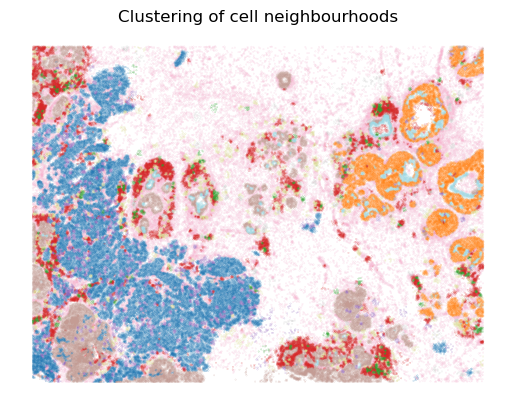

In [35]:
fig, ax = plt.subplots()
ax.scatter(adata.obs['x_centroid'], adata.obs["y_centroid"], c=adata.obs["cluster"], cmap="tab20", s=0.01)
ax.set_title("Clustering of cell neighbourhoods")
ax.axis("off")
plt.show()


In [9]:
model = PRISMO.load("/data/florin/prismo_project/prismo-analysis/application_xenium_florin/models/breast_cancer_factors_3_hallmark_30_hvg_4110_seed_59283")

In [26]:
factors_df = model.get_factors("pandas")["group_xenium"]
factors_df = pd.merge(factors_df, adata.obs[["celltype", "cluster"]], left_index=True, right_index=True)

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


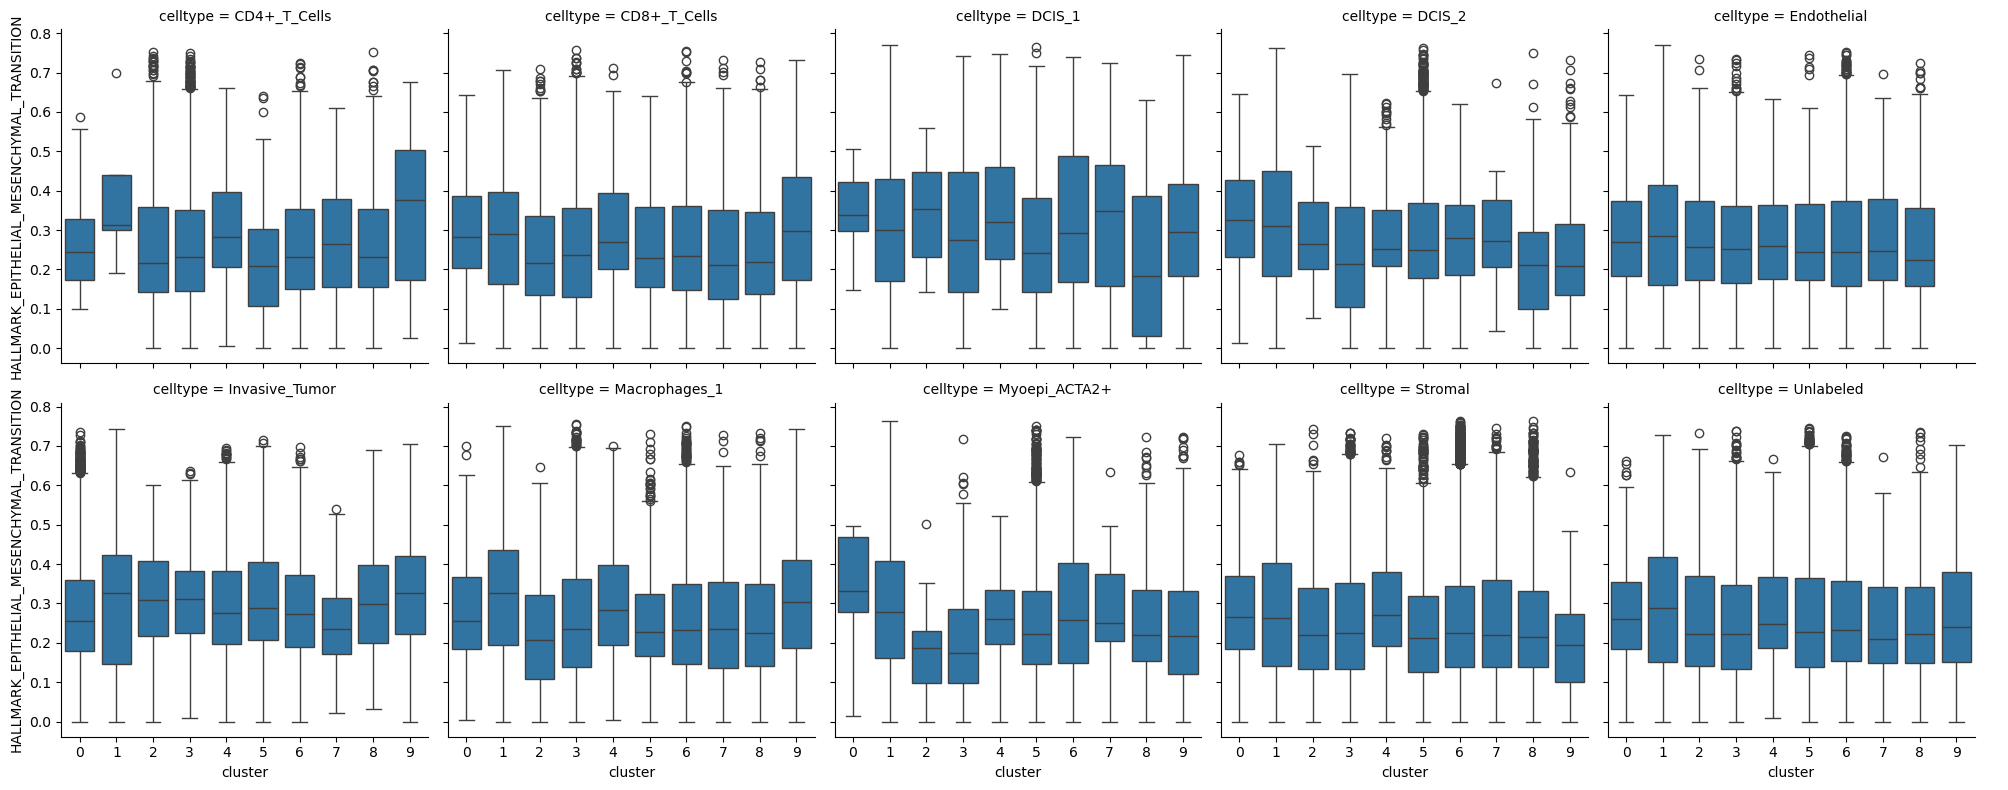

In [32]:
factor = "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
df = factors_df[["cluster", "celltype", factor]]

# get 10 most abundant celltypes from df
top10 = df["celltype"].value_counts().head(10).index
df = df[df.celltype.isin(top10)]
df["cluster"] = df["cluster"].astype("category").cat.remove_unused_categories()
df["celltype"] = df["celltype"].astype("category").cat.remove_unused_categories()

# Create a FacetGrid to visualize the relationship with the second categorical variable
g = sns.FacetGrid(df, col='celltype', height=4, aspect=1, col_wrap=5)
g.map(sns.boxplot, 'cluster', factor)
g.add_legend()
plt.show()

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


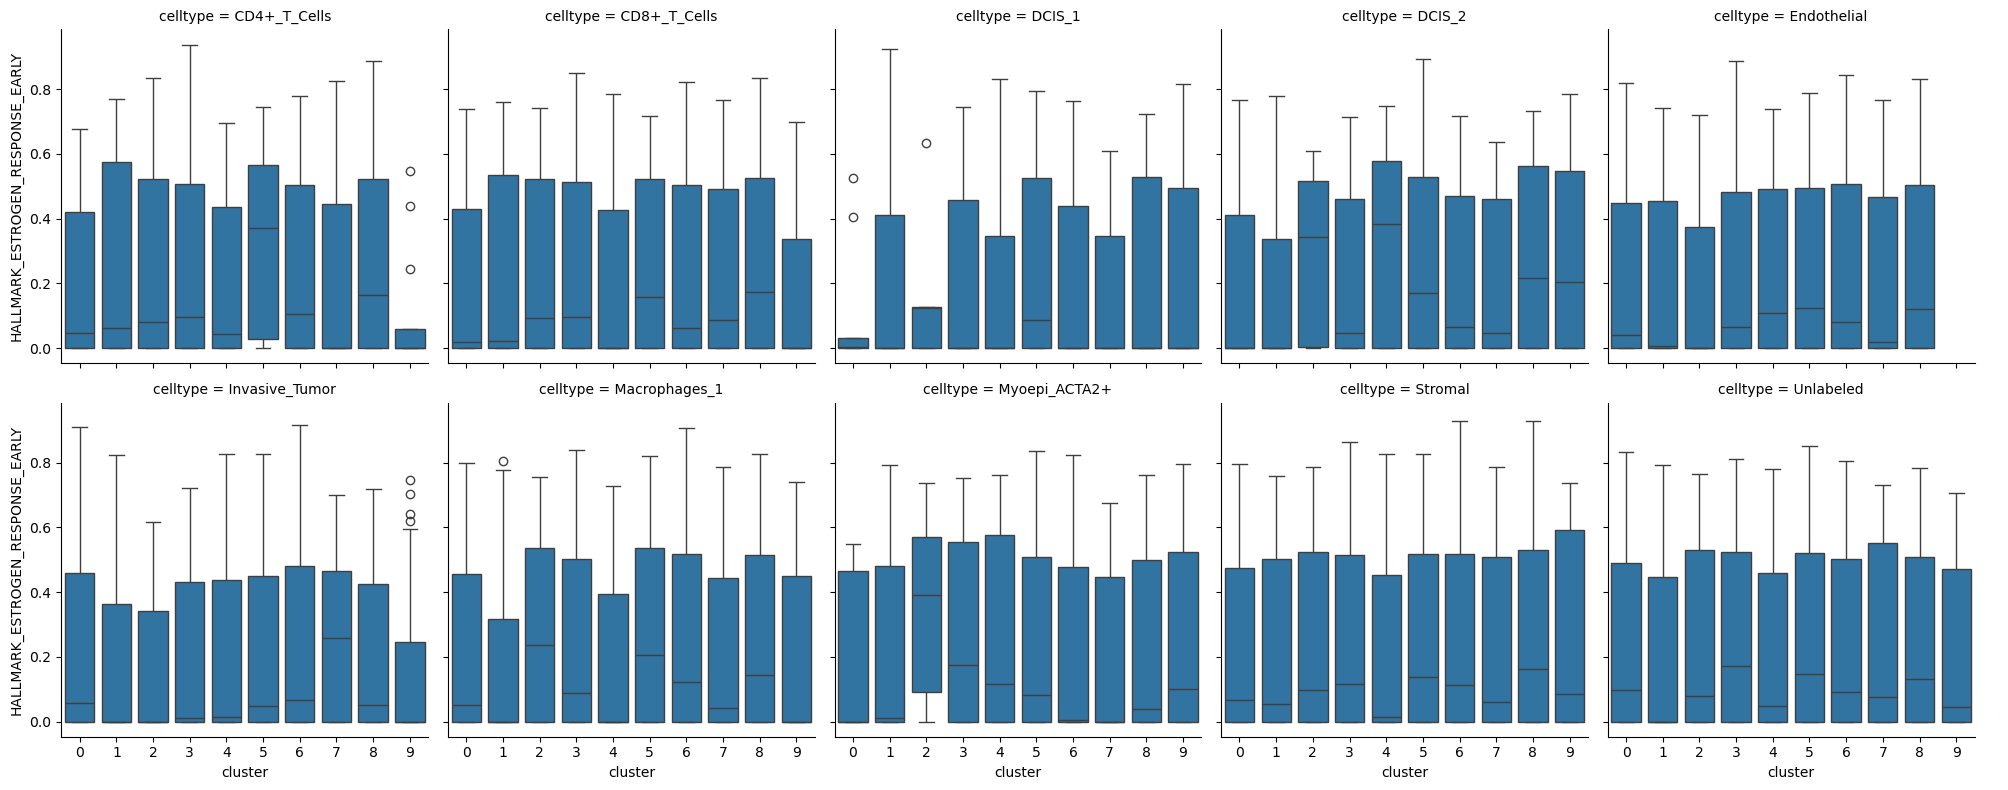

In [33]:
factor = "HALLMARK_ESTROGEN_RESPONSE_EARLY"
df = factors_df[["cluster", "celltype", factor]]

# get 10 most abundant celltypes from df
top10 = df["celltype"].value_counts().head(10).index
df = df[df.celltype.isin(top10)]
df["cluster"] = df["cluster"].astype("category").cat.remove_unused_categories()
df["celltype"] = df["celltype"].astype("category").cat.remove_unused_categories()

# Create a FacetGrid to visualize the relationship with the second categorical variable
g = sns.FacetGrid(df, col='celltype', height=4, aspect=1, col_wrap=5)
g.map(sns.boxplot, 'cluster', factor)
g.add_legend()
plt.show()

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


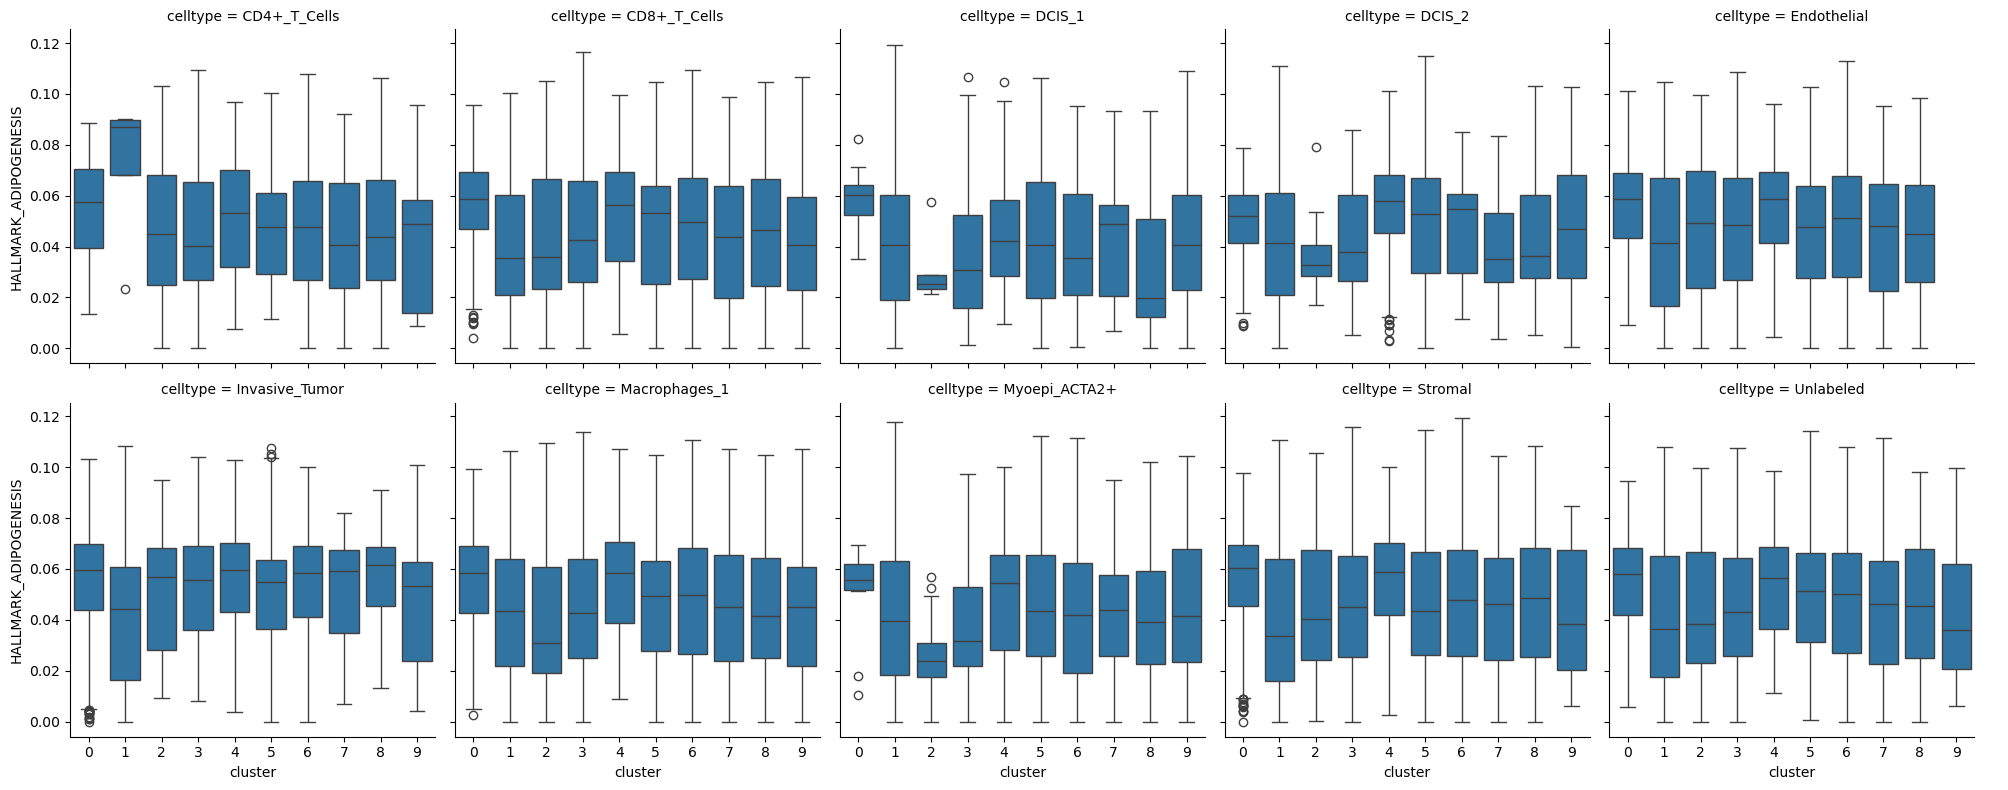

In [29]:
factor = "HALLMARK_ADIPOGENESIS"
df = factors_df[["cluster", "celltype", factor]]

# get 10 most abundant celltypes from df
top10 = df["celltype"].value_counts().head(10).index
df = df[df.celltype.isin(top10)]
df["cluster"] = df["cluster"].astype("category").cat.remove_unused_categories()
df["celltype"] = df["celltype"].astype("category").cat.remove_unused_categories()

# Create a FacetGrid to visualize the relationship with the second categorical variable
g = sns.FacetGrid(df, col='celltype', height=4, aspect=1, col_wrap=5)
g.map(sns.boxplot, 'cluster', factor)
g.add_legend()
plt.show()